<a href="https://colab.research.google.com/github/weixiadeng/pfam_msa/blob/main/Copy_of_MSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.4 MB/s eta 0:00:00


In [ ]:
pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
import scipy
import numpy as np
import requests
from io import StringIO
from itertools import permutations
import pandas as pd
from statistics import mean
import matplotlib.pyplot as plt
import json
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Read the fasta file from GitHub url
fa_url = "https://raw.githubusercontent.com/weixiadeng/pfam_msa/main/PF00712.fa"
fa_txt = StringIO(requests.get(fa_url).text)
# Convert the MSA to array, convert the gap to "-", all letter to uppercase
sequence_data_list = list(SeqIO.parse(fa_txt, "fasta"))
sequence_array = np.char.replace(np.char.upper(np.array(sequence_data_list)), ".", "-")

In [ ]:
# Compute H(a) for each column of MSA
sequence_array_size = sequence_array.shape
column_index_a = range(sequence_array_size[1])
entropy_a = dict()
for column_a in column_index_a:
    sequence_array_count = np.unique(sequence_array[:,column_a], return_counts = True)
    sequence_array_freq = sequence_array_count[1] / sequence_array_size[0]
    column_entropy = scipy.stats.entropy(sequence_array_freq)
    entropy_a[column_a] = column_entropy

In [ ]:
# Compute H(a, b) for each of two-column pair of MSA
column_index_a_b = list(permutations(range(sequence_array_size[1]), 2))
entropy_a_b = dict()
for column_a_b in column_index_a_b:
    sequence_array_count = np.unique(sequence_array[:,column_a_b],
                                     axis = 0, return_counts = True)
    sequence_array_freq = sequence_array_count[1] / sequence_array_size[0]
    column_entropy = scipy.stats.entropy(sequence_array_freq)
    entropy_a_b[column_a_b] = column_entropy

In [ ]:
# Compute MI(a,b) = H(a) + H(b) - H(a, b)
MI_a_b = dict()
for column_a_b in column_index_a_b:
    MI_a_b[column_a_b] = entropy_a[column_a_b[0]] + entropy_a[column_a_b[1]] - entropy_a_b[column_a_b]

In [ ]:
# Compute MI(a, x_bar)
MI_a_xbar = dict()
for column_a in column_index_a:
    MI_a_xbar_index = [item for item in column_index_a_b if column_a in item]
    MI_a_xbar[column_a] = mean(map(MI_a_b.get, MI_a_xbar_index))

In [ ]:
MI_bar = mean(MI_a_b.values())

In [ ]:
# Compute APC(a,b) = MI(a, x_bar) *  MI(b, x_bar) / MI_bar
APC_a_b = dict()
for column_a_b in column_index_a_b:
    APC_a_b[column_a_b] = MI_a_xbar[column_a_b[0]] * MI_a_xbar[column_a_b[1]] / MI_bar

In [ ]:
MI_a_b_df = pd.DataFrame.from_dict(MI_a_b, orient = "index")
MI_a_b_df.reset_index(inplace = True)
MI_a_b_df.columns = ["index", "MI"]

APC_a_b_df = pd.DataFrame.from_dict(APC_a_b, orient = "index")
APC_a_b_df.reset_index(inplace = True)
APC_a_b_df.columns = ["index", "APC"]

APC_MI = pd.merge(APC_a_b_df, MI_a_b_df, on = "index")

<Axes: xlabel='APC', ylabel='MI'>

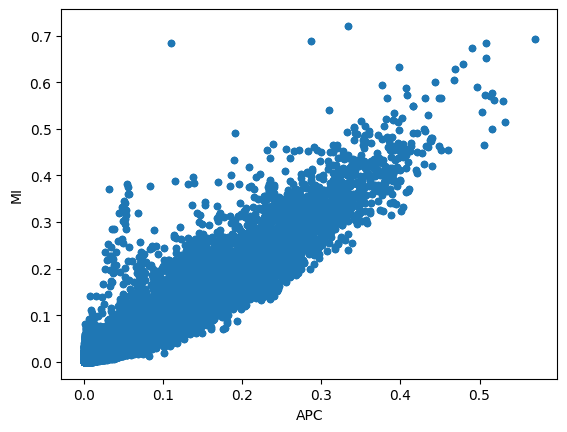

In [ ]:
APC_MI.plot.scatter(x = "APC", y = "MI")

Save output to json and csv

In [ ]:
x_a = json.dumps(entropy_a, indent = 4)
y_a = x_a.encode('utf-8')
with open("/content/gdrive/My Drive/pfam_data/entropy_a.json", "w") as f:
    f.write(str(y_a))

In [ ]:
dicts = copy.copy(entropy_a_b)
new_dct = {}
for k,v in dicts.items():
    new_dct[','.join(map(str, k))] = v

x_ab = json.dumps(new_dct, indent = 4)
y_ab = x_ab.encode('utf-8')
with open("/content/gdrive/My Drive/pfam_data/entropy_a_b.json", "w") as f:
    f.write(str(y_ab))

In [ ]:
dicts = copy.copy(MI_a_b)
new_dct = {}
for k,v in dicts.items():
    new_dct[','.join(map(str, k))] = v

x_ab = json.dumps(new_dct, indent = 4)
y_ab = x_ab.encode('utf-8')
with open("/content/gdrive/My Drive/pfam_data/MI_a_b.json", "w") as f:
    f.write(str(y_ab))

In [ ]:
MI_a_b_df = pd.DataFrame.from_dict(MI_a_b, orient = "index")
MI_a_b_df.reset_index(inplace = True)
with open("/content/gdrive/My Drive/pfam_data/MI_a_b.csv", "w") as f:
    MI_a_b_df.to_csv(f)

In [ ]:
MI_a_xbar_df = pd.DataFrame.from_dict(MI_a_xbar, orient = "index")
MI_a_xbar_df.reset_index(inplace = True)
with open("/content/gdrive/My Drive/pfam_data/MI_a_xbar.csv", "w") as f:
    MI_a_xbar_df.to_csv(f)

In [ ]:
dicts = copy.copy(APC_a_b)
new_dct = {}
for k,v in dicts.items():
    new_dct[','.join(map(str, k))] = v

x_ab = json.dumps(new_dct, indent = 4)
y_ab = x_ab.encode('utf-8')
with open("/content/gdrive/My Drive/pfam_data/APC_a_b.json", "w") as f:
    f.write(str(y_ab))

In [ ]:
with open("/content/gdrive/My Drive/pfam_data/APC_MI.csv", "w") as f:
    APC_MI.to_csv(f)